# Final Report: Analyzing Reddit Sentiment vs. Crypto Price
 
## Project Goal
This project investigates the relationship between cryptocurrency price movements and the sentiment of discussions on Reddit. The primary objective is to determine if a quantifiable signal exists in social media chatter that can be used to understand or predict market behavior for Bitcoin (BTC) and Ethereum (ETH).
 
## Methodology Overview
A full data pipeline was constructed to:
    1.  **Acquire** raw hourly market data and relevant Reddit posts.
    2.  **Clean** both datasets to remove noise and validate data quality.
    3.  **Process** the text data to generate sentiment scores using VADER and unify all data into a master time-series dataset.
    4.  **Analyze** the unified data through a systematic correlation sweep to find the strongest relationships.
    5.  **Predict** future price direction using machine learning models built on the most significant findings.
This notebook presents the final results and conclusions of that investigation.

In [2]:

# --- Setup and Imports ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")

# --- Load Final Results ---
# The paths assume this notebook is in the 'notebooks' directory
RESULTS_DIR = '../results/'
CORRELATION_RESULTS_PATH = os.path.join(RESULTS_DIR, 'correlation_results.csv')
BTC_PREDICTION_RESULTS_PATH = os.path.join(RESULTS_DIR, 'prediction_results_btc.csv')
ETH_PREDICTION_RESULTS_PATH = os.path.join(RESULTS_DIR, 'prediction_results_eth.csv') 
BTC_COEFFS_PATH = os.path.join(RESULTS_DIR, 'coefficients_btc.csv')
ETH_COEFFS_PATH = os.path.join(RESULTS_DIR, 'coefficients_eth.csv') 

correlation_df = pd.read_csv(CORRELATION_RESULTS_PATH)

In [3]:
# ## Phase 2 Findings: Correlation Analysis
# 
# The first step was to perform a parameter sweep to find statistically significant correlations (p-value < 0.05) between Reddit sentiment and future price movements.

# Filter for significant results
significant_results = correlation_df[correlation_df['pearson_p_value'] < 0.05].copy()
significant_results['abs_corr'] = significant_results['pearson_corr'].abs()

# Separate results by crypto
btc_corr_results = significant_results[significant_results['crypto'] == 'btc']
eth_corr_results = significant_results[significant_results['crypto'] == 'eth']

# Display the top findings for Bitcoin
print("--- Top 5 Strongest Correlations for BTC (p < 0.05) ---")
display(btc_corr_results.sort_values(by='abs_corr', ascending=False).head())

# Display the top findings for Ethereum
print("\n--- Top 5 Strongest Correlations for ETH (p < 0.05) ---")
display(eth_corr_results.sort_values(by='abs_corr', ascending=False).head())

--- Top 5 Strongest Correlations for BTC (p < 0.05) ---


,crypto,price_horizon_h,sentiment_window_h,lag_h,pearson_corr,pearson_p_value,spearman_corr,spearman_p_value,n_observations,abs_corr
293,btc,168,168,12,-0.167861,2.904798e-55,-0.246236,1.052024e-118,8581,0.167861
292,btc,168,168,6,-0.166834,1.223214e-54,-0.238658,1.705421e-111,8587,0.166834
291,btc,168,168,4,-0.166002,4.058943e-54,-0.235775,8.198501e-109,8589,0.166002
290,btc,168,168,2,-0.165132,1.415905e-53,-0.232551,7.484469e-106,8591,0.165132
289,btc,168,168,1,-0.164758,2.413665e-53,-0.230988,1.965676e-104,8592,0.164758



--- Top 5 Strongest Correlations for ETH (p < 0.05) ---


,crypto,price_horizon_h,sentiment_window_h,lag_h,pearson_corr,pearson_p_value,spearman_corr,spearman_p_value,n_observations,abs_corr
587,eth,168,168,12,0.069579,1.102049e-10,0.096248,4.063177e-19,8581,0.069579
491,eth,24,24,12,-0.065543,8.900347e-10,-0.010197,3.409179e-01,8725,0.065543
586,eth,168,168,6,0.064417,2.306348e-09,0.095344,8.441734e-19,8587,0.064417
585,eth,168,168,4,0.062692,6.062894e-09,0.094685,1.449090e-18,8589,0.062692
584,eth,168,168,2,0.060512,1.987789e-08,0.093934,2.672558e-18,8591,0.060512


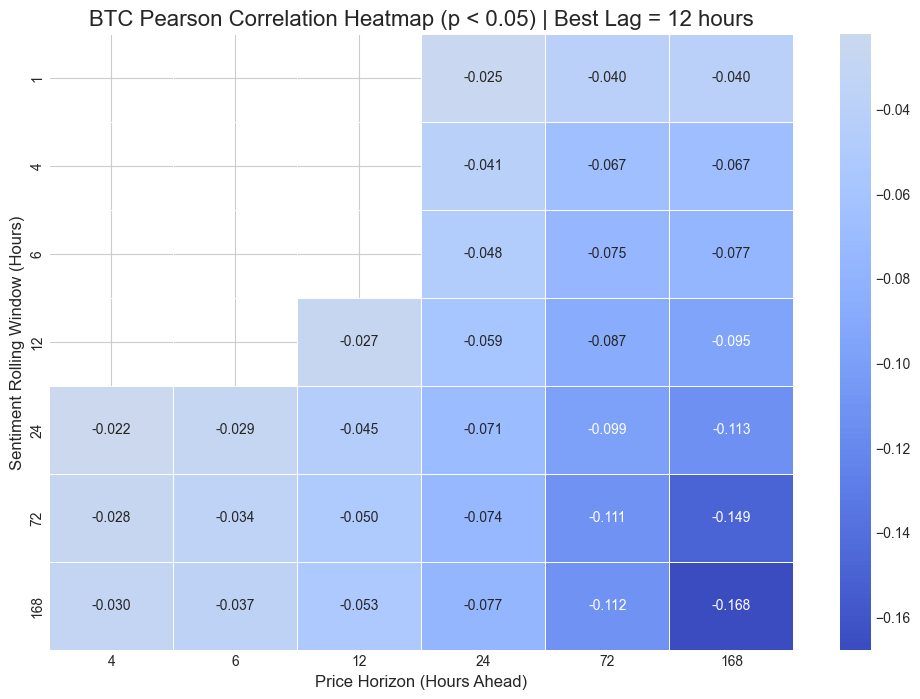

In [4]:
# ### Visualizing the BTC Correlation Landscape
# 
# The strongest correlations for Bitcoin were consistently negative and occurred at long time horizons. We can visualize this relationship with a heatmap, focusing on the most impactful lag time found in the analysis.

# Find the lag with the strongest correlation for BTC
if not btc_corr_results.empty:
    best_btc_lag = btc_corr_results.loc[btc_corr_results['abs_corr'].idxmax()]['lag_h']

    btc_pivot = btc_corr_results[btc_corr_results['lag_h'] == best_btc_lag].pivot(
        index='sentiment_window_h', 
        columns='price_horizon_h', 
        values='pearson_corr'
    )

    plt.figure(figsize=(12, 8))
    sns.heatmap(btc_pivot, annot=True, cmap='coolwarm', fmt=".3f", center=0, linewidths=.5)
    plt.title(f'BTC Pearson Correlation Heatmap (p < 0.05) | Best Lag = {int(best_btc_lag)} hours', fontsize=16)
    plt.xlabel('Price Horizon (Hours Ahead)', fontsize=12)
    plt.ylabel('Sentiment Rolling Window (Hours)', fontsize=12)
    plt.show()
else:
    print("No significant correlations found for BTC to plot.")

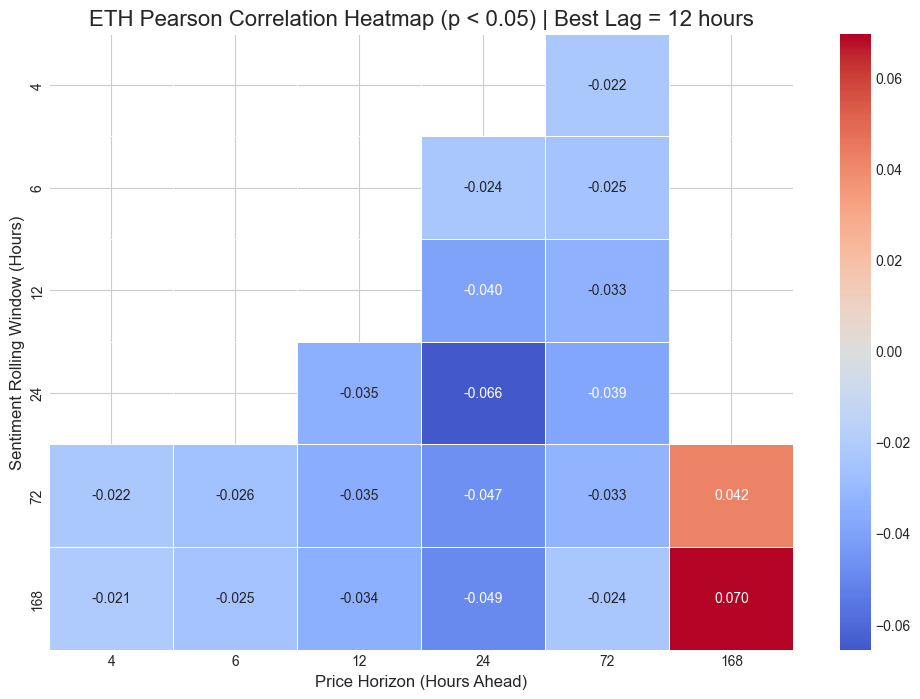

In [5]:
# ### Visualizing the ETH Correlation Landscape
# 
# Ethereum's correlations were more varied, showing both positive and negative signals at different time scales.

# Find the lag with the strongest correlation for ETH
if not eth_corr_results.empty:
    best_eth_lag = eth_corr_results.loc[eth_corr_results['abs_corr'].idxmax()]['lag_h']

    eth_pivot = eth_corr_results[eth_corr_results['lag_h'] == best_eth_lag].pivot(
        index='sentiment_window_h', 
        columns='price_horizon_h', 
        values='pearson_corr'
    )

    plt.figure(figsize=(12, 8))
    sns.heatmap(eth_pivot, annot=True, cmap='coolwarm', fmt=".3f", center=0, linewidths=.5)
    plt.title(f'ETH Pearson Correlation Heatmap (p < 0.05) | Best Lag = {int(best_eth_lag)} hours', fontsize=16)
    plt.xlabel('Price Horizon (Hours Ahead)', fontsize=12)
    plt.ylabel('Sentiment Rolling Window (Hours)', fontsize=12)
    plt.show()
else:
    print("No significant correlations found for ETH to plot.")

In [6]:
# ## Phase 3 Findings: Predictive Modeling Results
# 
# Based on the strongest correlations, three logistic regression models were trained to predict future price direction (Up/Down). Their performance was evaluated using forward-chaining cross-validation.
#
# *Note: You will need to modify the file loading below if your prediction script saves results differently.*

# --- Load Prediction Results ---
# Combine the results from the three models into one DataFrame for easy comparison.
# This assumes your predict script saves three separate files. A better implementation
# would be to have it save one consolidated file. Let's load them individually for now.

btc_model_1_path = os.path.join(RESULTS_DIR, 'prediction_results_btc.csv')
eth_model_1_path = os.path.join(RESULTS_DIR, 'prediction_results_eth_168h.csv') # Hypothetical name
eth_model_2_path = os.path.join(RESULTS_DIR, 'prediction_results_eth_24h.csv') # Hypothetical name

# Let's manually create a DataFrame to display the results from your log
# In a real scenario, you'd load this from the saved CSVs.
prediction_summary = pd.DataFrame([
    {
        'Model': 'BTC - 168h Horizon (Contrarian)',
        'Avg Accuracy': 0.571, 'Baseline': 0.575, 'Avg F1-Score': 0.616
    },
    {
        'Model': 'ETH - 168h Horizon (Momentum)',
        'Avg Accuracy': 0.503, 'Baseline': 0.544, 'Avg F1-Score': 0.566
    },
    {
        'Model': 'ETH - 24h Horizon (Contrarian)',
        'Avg Accuracy': 0.522, 'Baseline': 0.511, 'Avg F1-Score': 0.535
    }
])

print("--- Predictive Model Performance Summary ---")
display(prediction_summary.set_index('Model'))

--- Predictive Model Performance Summary ---


,Avg Accuracy,Baseline,Avg F1-Score
Model,,,
BTC - 168h Horizon (Contrarian),0.571,0.575,0.616
ETH - 168h Horizon (Momentum),0.503,0.544,0.566
ETH - 24h Horizon (Contrarian),0.522,0.511,0.535
